# Installing Dependencies

In [1]:
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from pycocotools.coco import COCO
import json

# Backgrounds
Function that pre-loads background paths so that they can loaded in the synthetic dataset generator

In [3]:
# load a background from the "backgrounds" folder and resize it to 416x416
background_path = os.path.join(os.getcwd(), 'backgrounds')

# get background paths
def get_background_paths(n=1000):
    background_path = os.path.join(os.getcwd(), 'backgrounds')
    texture_dirs = os.listdir(background_path)
    texture_dirs = [os.path.join(background_path, texture_dir) for texture_dir in texture_dirs]
    image_paths = []
    
    for i in range(n):
        texture_dir = random.choice(texture_dirs)
        image_name = random.choice(os.listdir(texture_dir))
        image_path = os.path.join(texture_dir, image_name)
        image_paths.append(image_path)

    return image_paths

['c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\crosshatched\\crosshatched_0085.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\polka-dotted\\polka-dotted_0159.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\polka-dotted\\polka-dotted_0130.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\grooved\\grooved_0158.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\zigzagged\\zigzagged_0119.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\meshed\\meshed_0137.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\bubbly\\bubbly_0097.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\freckled\\freckled_0070.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\chequered\\chequered_0064.jpg',
 'c:\\Users\\Michael\\Desktop\\Flesh_and_Blood_Dataset\\backgrounds\\scaly\\scaly_0197.jpg'

# Rotate Image
Helper function that rotates an image without cropping the sides

In [9]:
# Source: https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

# Overlap
Function that calculates the overlap between two boxes.

In [5]:
def overlap(top_left1, bottom_right1, top_left2, bottom_right2, threshold=0.30):
    # Check if two rectangles overlap by more than 50%
    x_overlap = max(0, min(bottom_right1[0], bottom_right2[0]) - max(top_left1[0], top_left2[0]))
    y_overlap = max(0, min(bottom_right1[1], bottom_right2[1]) - max(top_left1[1], top_left2[1]))
    overlap_area = x_overlap * y_overlap
    area_rect2 = (bottom_right2[0] - top_left2[0]) * (bottom_right2[1] - top_left2[1])
    return overlap_area / area_rect2 > threshold

#  Generate Dataset
Function used to generate N images. Also creates COCO annotations.

In [6]:
# generate an image which is a background and with images of cards placed on the foreground
# cards are randomly rotated 
# cards can be found in cards folder
# cards are randomly resized to be 50 to 100 pixels in height

# also creates COCO style annotations for dataset

def generate_dataset(num_imgs=5):

    card_list = [
    "bittering_thorns",
    "brutal_assault",
    "edge_of_autumn",
    "flying_kick",
    "head_jab",
    "ira_crimson_haze",
    "lunging_press",
    "salt_the_wound",
    "scar_for_a_scar",
    "springboard_somersault",
    "torrent_of_tempo",
    "whirling_mist_blossom"
    ]

    # initialize coco dataset
    coco = COCO()
    coco.dataset['images'] = []
    coco.dataset['categories'] = []
    coco.dataset['annotations'] = []
    coco.createIndex()
    
    # add super category Cards
    card_cat = {'supercategory': 'Cards', 'id': 0, 'name': 'Cards'}
    coco.dataset['categories'].append(card_cat)

    # add each card as a category
    for i, card in enumerate(card_list):
        cat = {'supercategory': 'Cards', 'id': i + 1, 'name': card}
        coco.dataset['categories'].append(cat)

    img_dir = os.path.join(os.getcwd(), 'dataset')
    backgrounds = get_background_paths(num_imgs)

    for i, b in enumerate(backgrounds):

        # load background
        background = cv2.imread(b)
        background = cv2.resize(background, (416, 416))

        # add image to coco dataset
        # i should have leading zeros to make it 6 digits long
        img_name = str(i).zfill(6) + '.jpg'
        img_path = os.path.join(img_dir, img_name)

        # add image to coco dataset
        print('adding image', img_name)
        img = {'file_name': img_name, 'height': 416, 'width': 416, 'id': i}
        coco.dataset['images'].append(img)

        num_cards = random.choice([1, 2, 2, 3, 3, 3, 4, 5])

        card_coords = []

        for j in range(num_cards):
            scale = 0.25
            card_name = random.choice(card_list)
            card_path = os.path.join(os.getcwd(), 'cards', card_name + '.png')
            card = cv2.imread(card_path, cv2.IMREAD_UNCHANGED)
            card_h, card_w, _ = card.shape
            card = cv2.resize(card, (int(card_w * scale), int(card_h * scale)))
            card = rotate_image(card, random.randint(-45, 45))

            card_h, card_w, _ = card.shape
            background_h, background_w, _ = background.shape

            x = random.randint(0, background_w - card_w)
            y = random.randint(0, background_h - card_h)

            for k in range(100):
                print('k=', k)
                if k == 99:
                    break
                overlap_flag = False
                for c in card_coords:
                    if overlap((x, y), (x + card_w, y + card_h), c[0], c[1]):
                        print('overlap')
                        overlap_flag = True
                        break
                if overlap_flag:
                    x = random.randint(0, background_w - card_w)
                    y = random.randint(0, background_h - card_h)
                else:
                    break

            bbox = [x, y, card_w, card_h]

            print('adding annotation for img', i)
            ann = {'category_id': card_list.index(card_name) + 1, 'image_id': i, 'bbox': bbox, 'iscrowd': 0, 'area': bbox[2] * bbox[3]}
            print('adding annotation', ann)
            coco.dataset['annotations'].append(ann)

            card_coords.append(((x, y), (x + card_w, y + card_h)))

            print(card_coords)

            # add card to background with respect to alpha channel
            alpha_card = card[:, :, 3] / 255.0
            alpha_background = 1.0 - alpha_card

            for c in range(0,3):
                background[y:y+card_h, x:x+card_w, c] = (alpha_card * card[:, :, c] + alpha_background * background[y:y+card_h, x:x+card_w, c])

        # save image
        cv2.imwrite(img_path, background)

    return coco

# Create Synthetic Dataset

In [7]:
data = generate_dataset(2500)

# save coco dataset to dataset folder
data_path = os.path.join(os.getcwd(), 'dataset', 'annos.coco.json')

# save coco dataset to json file
with open(data_path, 'w') as f:
    json.dump(data.dataset, f)

creating index...
index created!
adding image 000000.jpg
k= 0
adding annotation for img 0
adding annotation {'category_id': 12, 'image_id': 0, 'bbox': [163, 128, 182, 192], 'iscrowd': 0, 'area': 34944}
[((163, 128), (345, 320))]
k= 0
adding annotation for img 0
adding annotation {'category_id': 10, 'image_id': 0, 'bbox': [14, 19, 132, 171], 'iscrowd': 0, 'area': 22572}
[((163, 128), (345, 320)), ((14, 19), (146, 190))]
k= 0
overlap
k= 1
adding annotation for img 0
adding annotation {'category_id': 3, 'image_id': 0, 'bbox': [131, 0, 185, 192], 'iscrowd': 0, 'area': 35520}
[((163, 128), (345, 320)), ((14, 19), (146, 190)), ((131, 0), (316, 192))]
k= 0
overlap
k= 1
overlap
k= 2
adding annotation for img 0
adding annotation {'category_id': 9, 'image_id': 0, 'bbox': [288, 68, 127, 167], 'iscrowd': 0, 'area': 21209}
[((163, 128), (345, 320)), ((14, 19), (146, 190)), ((131, 0), (316, 192)), ((288, 68), (415, 235))]
k= 0
overlap
k= 1
overlap
k= 2
overlap
k= 3
overlap
k= 4
adding annotation for

# Visualize Sample

{'file_name': '000005.jpg', 'height': 416, 'width': 416, 'id': 5}
{'category_id': 12, 'image_id': 5, 'bbox': [22, 201, 166, 188], 'iscrowd': 0, 'area': 31208}
{'category_id': 1, 'image_id': 5, 'bbox': [35, 88, 132, 171], 'iscrowd': 0, 'area': 22572}
{'category_id': 7, 'image_id': 5, 'bbox': [167, 192, 180, 192], 'iscrowd': 0, 'area': 34560}


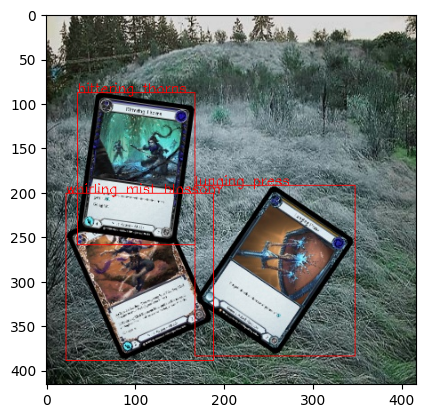

In [138]:
# load coco dataset from json file
with open(data_path, 'r') as f:
    data = json.load(f)

# get img
img_info = random.choice(data['images'])
img_path = os.path.join(os.getcwd(), 'dataset', img_info['file_name'])
img = cv2.imread(img_path)

# get annotations and draw bounding boxes with labels
anns = data['annotations']
cats = data['categories']

print(img_info)
img_ann = [a for a in anns if a['image_id'] == img_info['id']]
for i in img_ann: 
    print(i)

for i in img_ann:
    bbox = i['bbox']
    cat_id = i['category_id']
    cat_name = [c for c in cats if c['id'] == cat_id][0]['name']
    cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (255, 0, 0))
    cv2.putText(img, cat_name, (int(bbox[0]), int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))

plt.imshow(img)